# Project 01 - Color Compression

## Thông tin sinh viên

- Họ và tên: Nguyễn Phương Thảo
- MSSV: 23127306
- Lớp: 23CLC08

## Import các thư viện liên quan

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import os
import time

## Helper functions

In [2]:
def read_img(img_path):
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image (2D)
    '''

    img = Image.open(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at path: {img_path}")
    img = img.convert('RGB')
    image_np = np.array(img)
    return image_np


def show_img(img_2d):
    '''
    Show image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    '''
    plt.imshow(img_2d)
    plt.axis('off')
    plt.show()


def save_img(img_2d, img_path):
    '''
    Save image to img_path

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    img_path : str
        Path of image
    '''
    img = Image.fromarray(img_2d.astype(np.uint8), mode='RGB')
    img.save(img_path)

def convert_img_to_1d(img_2d):
    '''
    Convert 2D image to 1D image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)

    Returns
    -------
        Image (1D)
    '''

    return img_2d.reshape(-1, 3)


def kmeans(img_1d, k_clusters, max_iter, init_centroids='random'):
    '''
    K-Means algorithm

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    '''
    # Initialize centroids based on the chosen method
    centroids = initialize_centroids(img_1d, k_clusters, init_centroids)        
    
    for _ in range(max_iter):
        # Assign each pixel to the nearest centroid
        labels = assign_clusters(img_1d, centroids)
        
        # Compute new centroids as mean of assigned pixels                            
        new_centroids = update_centroids(img_1d, labels, k_clusters)            

        # Stop if centroids have converged (small change)
        if np.allclose(centroids, new_centroids, atol=1e-4):
            break
        
        # Update centroids for next iteration
        centroids = new_centroids
        
    # Convert centroids to valid uint8 RGB values
    centroids = centroids.astype(np.uint8)
    return centroids, labels


def generate_2d_img(img_2d_shape, centroids, labels):
    '''
    Generate a 2D image based on K-means cluster centroids

    Parameters
    ----------
    img_2d_shape : tuple (height, width, 3)
        Shape of image
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids
    labels : np.ndarray with shape=(height * width, )
        Store label for pixels (cluster's index on which the pixel belongs)

    Returns
    -------
        New image (2D)
    '''
    # Assign each pixel the color of its cluster centroid
    new_img_1d = centroids[labels].astype(np.uint8)
    new_img_2d = new_img_1d.reshape(img_2d_shape)

    return new_img_2d

# Your additional functions here

# Initialize centroids using different methods
def initialize_centroids(img_1d, k_clusters, init_centroids):
    num_pixels = img_1d.shape[0]    # Total number of pixels
    num_channels = img_1d.shape[1]  # Number of color channels
    
    if init_centroids == 'random':
        centroids = np.random.randint(0, 256, size=(k_clusters, num_channels)).astype(np.float32)
    elif init_centroids == 'in_pixels':
        indices = np.random.choice(num_pixels, k_clusters, replace=False)
        centroids = img_1d[indices].astype(np.float32)
    elif init_centroids == 'kmeans++':
        centroids =init_kmeans_plus_plus(img_1d, k_clusters)
    return centroids

# K-means++ initialization
def init_kmeans_plus_plus(img_1d, k_clusters):
    n_pixels = img_1d.shape[0]
    centroids = np.empty((k_clusters, img_1d.shape[1]), dtype=np.float32)

    #Choose the first centroid randomly
    first_idx = np.random.choice(n_pixels)
    centroids[0] = img_1d[first_idx]

    #Compute initial distances to the first centroid
    dists = np.linalg.norm(img_1d - centroids[0], axis=1) ** 2

    for i in range(1, k_clusters):
        # Compute selection probability proportional to distance squared
        probs = dists / np.sum(dists)

        # Select next centroid based on probability
        next_idx = np.random.choice(n_pixels, p=probs)
        centroids[i] = img_1d[next_idx]

        # Update distances to the nearest centroid so far
        new_dists = np.linalg.norm(img_1d - centroids[i], axis=1) ** 2
        dists = np.minimum(dists, new_dists)

    return centroids

# Assign each pixel to the nearest centroid
def assign_clusters(img_1d, centroids):
    pixels = img_1d[:, np.newaxis]              # shape: (num_pixels, 1, 3)
    centers = centroids[np.newaxis, :]          # shape: (1, k_clusters, 3)
    diff = pixels - centers                     # Broadcasted subtraction
    distances = np.linalg.norm(diff, axis=2)    # Euclidean distances
    return np.argmin(distances, axis=1)         # Index of nearest centroid

# Compute new centroids as the mean of assigned pixels
def update_centroids(img_1d, labels, k_clusters):
    centroids = np.zeros((k_clusters, 3))
    for i in range(k_clusters):
        cluster_pixels = img_1d[labels == i]
        if len(cluster_pixels) > 0:
            centroids[i] = np.mean(cluster_pixels, axis=0)
        else:
            # If a cluster is empty, randomly pick a pixel as new centroid
            random_index = np.random.choice(img_1d.shape[0])
            centroids[i] = img_1d[random_index].astype(np.float32)
    return centroids


def mini_batch_kmeans(img_1d, k_clusters, max_iter, batch_size=1000, init_centroids='random'):
    
    n_pixels = img_1d.shape[0]                                              
    centroids = initialize_centroids(img_1d, k_clusters, init_centroids) 

    for _ in range(max_iter):
        # Randomly sample a mini-batch
        batch_indices = np.random.choice(n_pixels, batch_size, replace=False)     
        batch = img_1d[batch_indices]

        # Assign clusters for mini-batch
        batch_labels = assign_clusters(batch, centroids)

        # Update centroids incrementally based on mini-batch
        for i in range(k_clusters):
            points_in_cluster = batch[batch_labels == i]
            if len(points_in_cluster) > 0:
                centroid_mean = np.mean(points_in_cluster, axis=0)
                centroids[i] = (centroids[i] + centroid_mean) / 2
            else:
            # If a cluster is empty, randomly pick a pixel as new centroid
                random_index = np.random.choice(img_1d.shape[0])
                centroids[i] = img_1d[random_index].astype(np.float32)

    # Label for full image
    labels = assign_clusters(img_1d, centroids)
    centroids = centroids.astype(np.uint8)
    return centroids, labels

# Compress an image using K-means
def compress_image(image_path, k_clusters, max_iter, init_method):
    original_img = read_img(image_path)                                 # Read image
    img_1d = convert_img_to_1d(original_img)                            # Convert image to 1D array
    centroids, labels = kmeans(img_1d, k_clusters, max_iter, init_method)        # Run KMeans
    new_img = generate_2d_img(original_img.shape, centroids, labels)    
    return new_img, original_img

def compress_image_mini_batch(image_path, k_clusters, max_iter, init_method):
    original_img = read_img(image_path)                                
    img_1d = convert_img_to_1d(original_img)                            
    centroids, labels = mini_batch_kmeans(img_1d, k_clusters, max_iter, batch_size=1000, init_centroids=init_method)
    new_img = generate_2d_img(original_img.shape, centroids, labels)    
    return new_img, original_img


## Your tests

In [ ]:
def test_k_values(image_path, k_list=[3, 5, 7, 10, 15, 20], max_iter=50, init_centroids='random'):
    img = read_img(image_path)
    img_1d = convert_img_to_1d(img)

    results = []
    for k in k_list:
        start_time = time.time()
        centroids, labels = kmeans(img_1d, k, max_iter, init_centroids)
        duration = time.time() - start_time

        new_img = generate_2d_img(img.shape, centroids, labels)
        results.append({
            "k": k,
            "img": new_img,
            "time": duration
        })

    results.append({
        "k": "original",
        "img": img,
        "time": 0.0
    })
    n = len(results)
    plt.figure(figsize=(4 * n, 5))

    for i, result in enumerate(results):
        plt.subplot(1, n, i + 1)
        plt.imshow(result["img"])
        if result["k"] == "original":
            plt.title("Original Image")
        else:
            plt.title(f"k = {result['k']}\nTime = {result['time']:.2f}s")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def test_kmeans_vs_minibatch_multiple_k(image_path, k_list=[3, 5, 10], max_iter=50, init_centroids='random'):
    img = read_img(image_path)
    img_1d = convert_img_to_1d(img)

    n = len(k_list)
    plt.figure(figsize=(6 * n, 6))

    for idx, k in enumerate(k_list):
        # KMeans
        start = time.time()
        centroids_k, labels_k = kmeans(img_1d, k, max_iter, init_centroids)
        time_kmeans = time.time() - start
        img_k = generate_2d_img(img.shape, centroids_k, labels_k)

        # Mini-Batch KMeans
        start = time.time()
        centroids_mb, labels_mb = mini_batch_kmeans(img_1d, k, max_iter, batch_size=1000, init_centroids=init_centroids)
        time_mb = time.time() - start
        img_mb = generate_2d_img(img.shape, centroids_mb, labels_mb)

        plt.subplot(2, n, idx + 1)
        plt.imshow(img_k)
        plt.title(f"K-Means\nk={k}, {time_kmeans:.2f}s")
        plt.axis('off')

        plt.subplot(2, n, idx + 1 + n)
        plt.imshow(img_mb)
        plt.title(f"Mini-Batch\nk={k}, {time_mb:.2f}s")
        plt.axis('off')

    plt.tight_layout()
    plt.show()



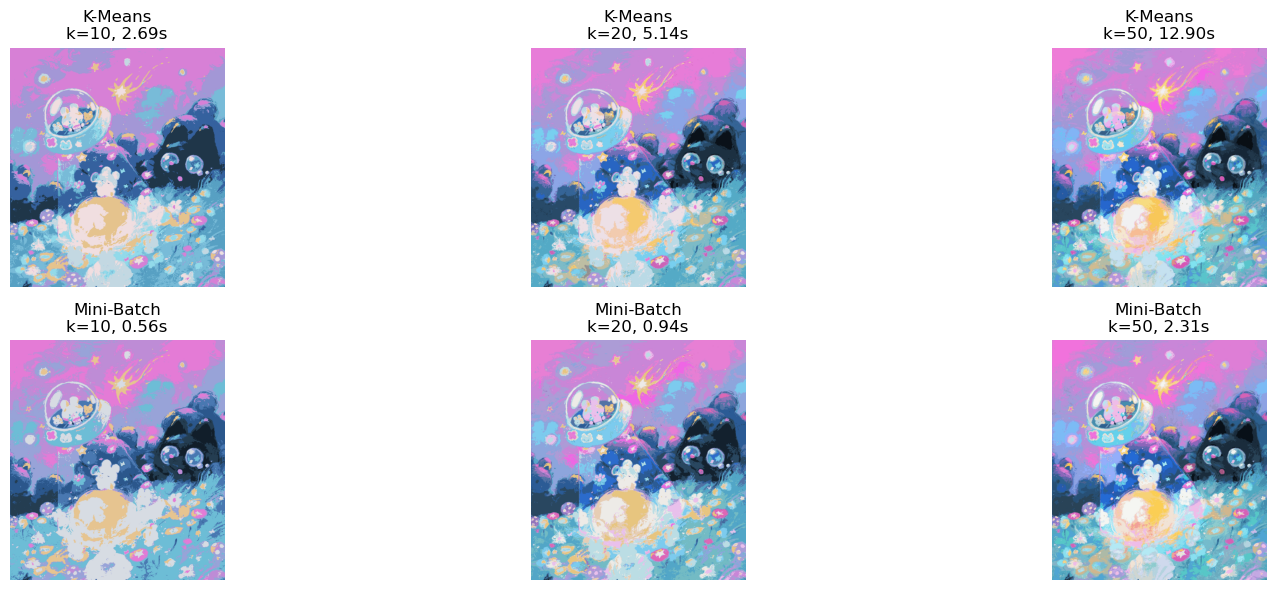

In [4]:
test_kmeans_vs_minibatch_multiple_k("test4.jpg", k_list=[10, 20, 50], max_iter=10, init_centroids='kmeans++')

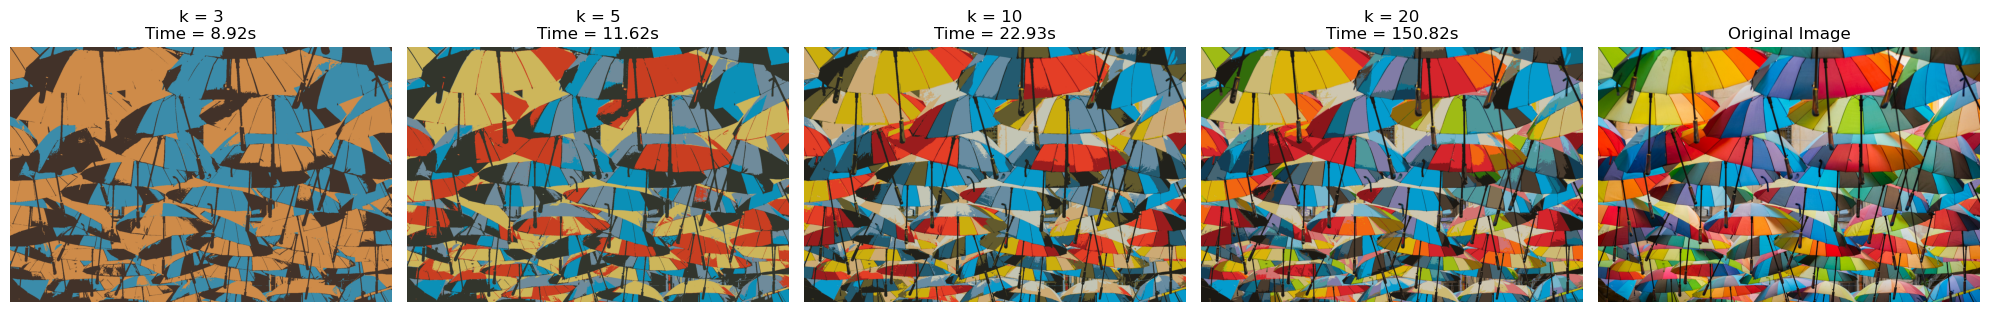

In [ ]:
# Test different k values
test_k_values("test1.jpg", k_list=[3, 5, 10, 20], init_centroids="random")

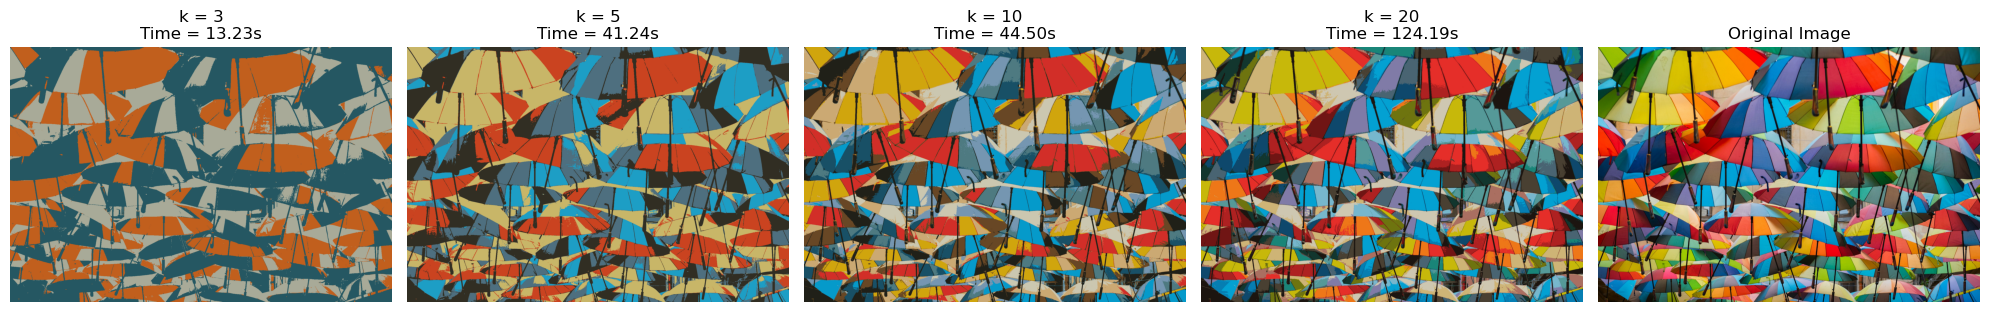

In [70]:
test_k_values("test1.jpg", k_list=[3, 5, 10, 20], init_centroids="in_pixels")

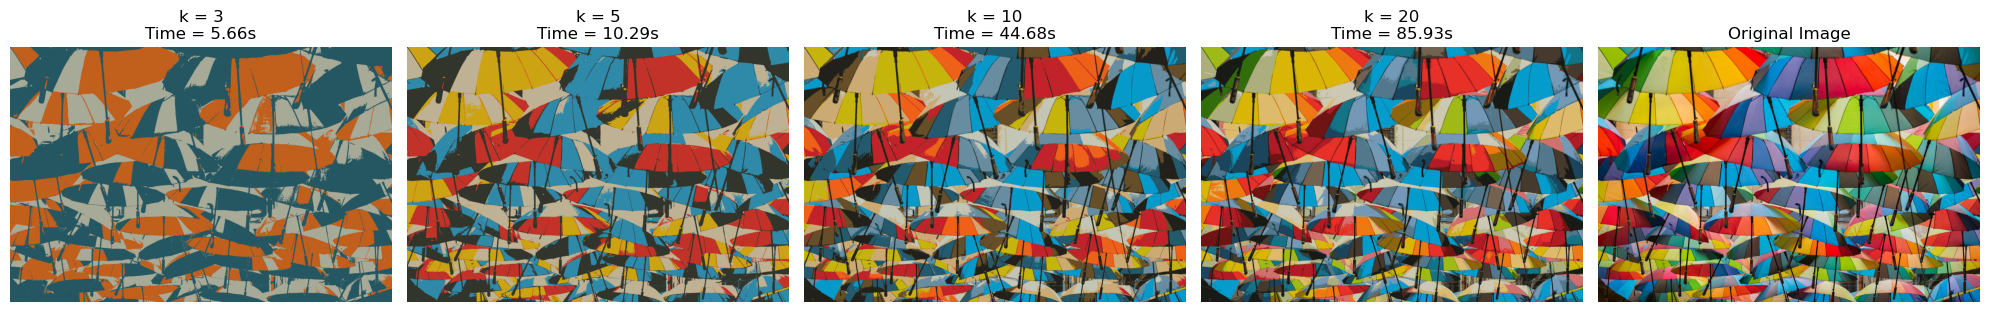

In [71]:
test_k_values("test1.jpg", k_list=[3, 5, 10, 20], init_centroids="kmeans++")

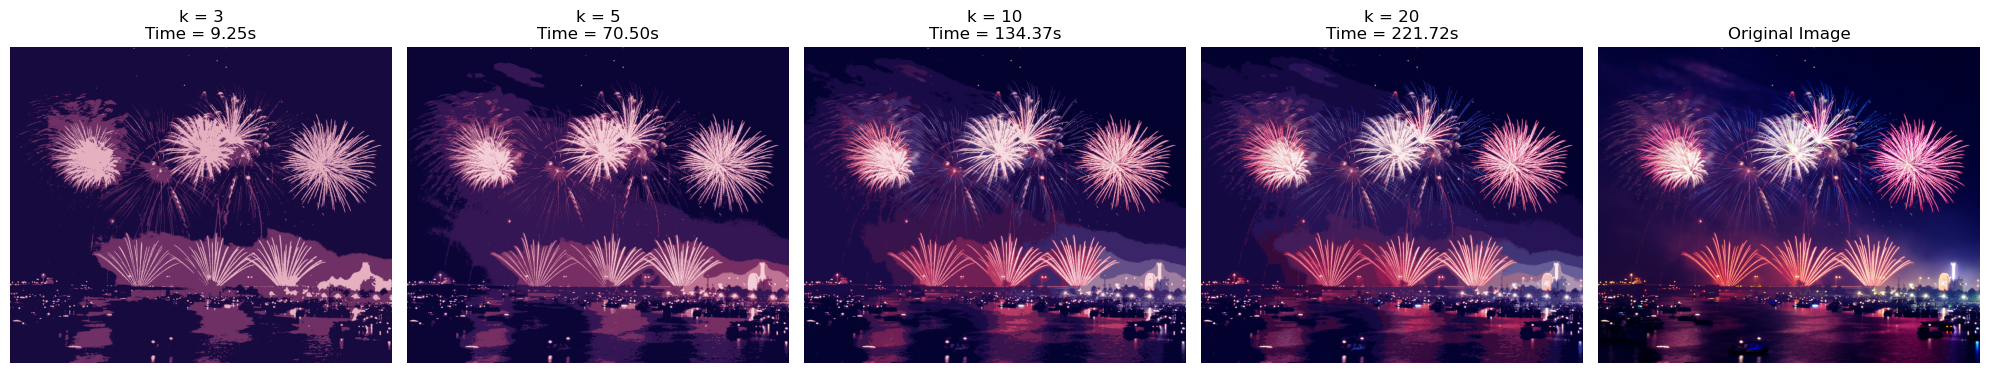

In [84]:
test_k_values("test3.jpg", k_list=[3, 5, 10, 20], init_centroids="random")

## Main FUNCTION

In [16]:
# YOUR CODE HERE

def main():

    image_path = input("Enter input image file name (e.g., test.jpg): ").strip()
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return
    
    k = int(input("Enter the number of color clusters (k): "))
    
    max_iter = int(input("Enter the max number of iterations: "))
    
    init_method = input("Enter centroid init method (random | in_pixels | kmeans++): ").strip()
    
    if init_method not in ['random', 'in_pixels', 'kmeans++']:
        print("Invalid method. Must be one of: random, in_pixels, kmeans++.")
        return

    # Compress image
    compressed_img, original_img = compress_image(image_path, k, max_iter, init_method)

    # Show images
    print("Original image:")
    show_img(original_img)
    print("Compressed image:")
    show_img(compressed_img)


    # Save compressed image in PNG and PDF
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    suffix = f"_k{k}_{init_method}"
    png_path = f"{base_filename}{suffix}.png"
    pdf_path = f"{base_filename}{suffix}.pdf"
    
    save_img(compressed_img, png_path)
    save_img(compressed_img, pdf_path)
    
    print(f"Compressed image saved as:\n- {png_path}\n- {pdf_path}")

Original image:


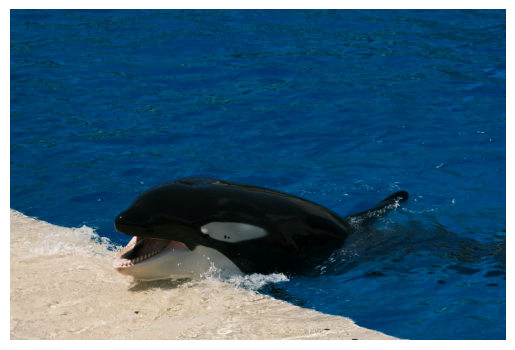

Compressed image:


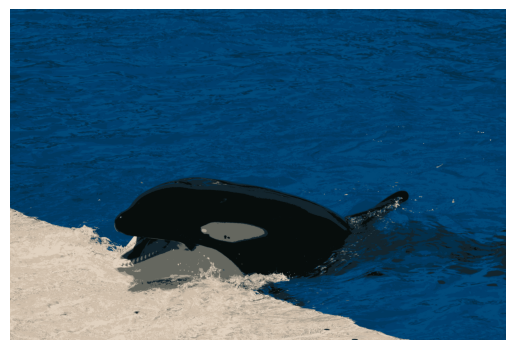

Compressed image saved as:
- test6_k10_kmeans++.png
- test6_k10_kmeans++.pdf


In [18]:
# Call main function
main()

In [9]:
def main_mini_batch():

    image_path = input("Enter input image file name (e.g., test.jpg): ").strip()
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return
    
    k = int(input("Enter the number of color clusters (k): "))
    
    max_iter = int(input("Enter the max number of iterations: "))
    
    init_method = input("Enter centroid init method (random | in_pixels | kmeans++): ").strip()
    
    if init_method not in ['random', 'in_pixels', 'kmeans++']:
        print("Invalid method. Must be one of: random, in_pixels, kmeans++.")
        return

    # Compress image
    compressed_img, original_img = compress_image_mini_batch(image_path, k, max_iter, init_method)

    # Show images
    print("Original image:")
    show_img(original_img)
    print("Compressed image:")
    show_img(compressed_img)


    # Save compressed image in PNG and PDF
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    suffix = f"_k{k}_{init_method}"
    png_path = f"{base_filename}{suffix}.png"
    pdf_path = f"{base_filename}{suffix}.pdf"
    
    save_img(compressed_img, png_path)
    save_img(compressed_img, pdf_path)
    
    print(f"Compressed image saved as:\n- {png_path}\n- {pdf_path}")

Original image:


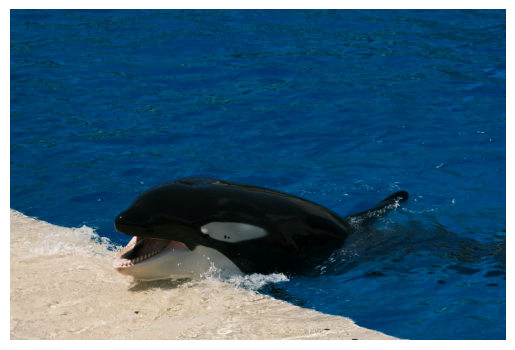

Compressed image:


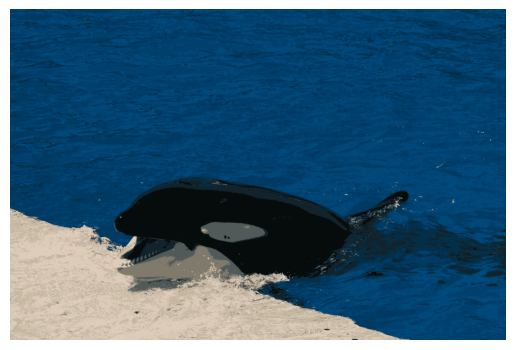

Compressed image saved as:
- test6_k10_kmeans++.png
- test6_k10_kmeans++.pdf


In [10]:
main_mini_batch()